# KNN Imputation: Terry Stops Dataset

Now we're going to work on seeing how well KNN Imputation works on a dataset that is composed mostly of categorical data.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions import cat_codes

In [2]:
t_stops = pd.read_csv('datasets/terry_stops/eda_clean.csv')
t_stops = t_stops.drop('Unnamed: 0', axis=1)
t_stops.head()

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,initial_call_type,final_call_type,call_type,arrest_flag,frisk_flag,precinct,sector,beat,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,dif_race,dif_gender,dif_race_gender,12am_6am,7am_12pm,1pm_6pm,7pm_11pm
0,Unknown,unassigned,20150000110760,33273,Offense Report,None,6355,F,White,White,F,DIST - IP/JO - DV DIST - NO ASLT,"--DV - ARGUMENTS, DISTURBANCE (NO ARREST)",911,N,N,East,E,E1,N,2015,4,45,n,y,N,N,Y,0,1,0,0
1,Unknown,unassigned,20150000110760,33274,Offense Report,None,6355,F,White,White,M,DIST - IP/JO - DV DIST - NO ASLT,"--DV - ARGUMENTS, DISTURBANCE (NO ARREST)",911,N,N,East,E,E1,N,2015,4,45,n,y,N,Y,Y,0,1,0,0
2,Unknown,unassigned,20150000120532,35462,Arrest,None,7735,M,White,Not Specified,Unable to Determine,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - CAR PROWL,911,N,Y,East,C,C2,N,2015,4,24,n,n,Y,Y,Y,0,0,1,0
3,Unknown,unassigned,20150000127841,36993,Offense Report,None,7474,F,White,Not Specified,Unable to Determine,"DISTURBANCE, MISCELLANEOUS/OTHER","--DV - ARGUMENTS, DISTURBANCE (NO ARREST)",911,N,N,East,C,C3,N,2015,4,46,n,y,Y,Y,Y,0,0,1,0
4,Unknown,unassigned,20150000145811,41041,Arrest,None,4835,M,White,Not Specified,M,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,N,N,East,E,E1,N,2015,5,56,n,n,Y,N,Y,0,0,1,0


# Preprocessing
Need to drop unusable columns such as unique IDs.

In [3]:
t_stops = t_stops.drop(['subject_id', 'go_sc_num', 'terry_stop_id', 
                        'officer_id'], axis=1)
t_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30364 entries, 0 to 30363
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   subject_age_group         30364 non-null  object
 1   stop_resolution           30364 non-null  object
 2   weapon_type               30364 non-null  object
 3   officer_gender            30364 non-null  object
 4   officer_race              30364 non-null  object
 5   subject_perceived_race    30364 non-null  object
 6   subject_perceived_gender  30364 non-null  object
 7   initial_call_type         30364 non-null  object
 8   final_call_type           30364 non-null  object
 9   call_type                 30364 non-null  object
 10  arrest_flag               30364 non-null  object
 11  frisk_flag                30364 non-null  object
 12  precinct                  30364 non-null  object
 13  sector                    30364 non-null  object
 14  beat                  

In [4]:
# Label encoding
cat_codes(t_stops, t_stops.columns)
t_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30364 entries, 0 to 30363
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   subject_age_group         30364 non-null  int8 
 1   stop_resolution           30364 non-null  int8 
 2   weapon_type               30364 non-null  int8 
 3   officer_gender            30364 non-null  int8 
 4   officer_race              30364 non-null  int8 
 5   subject_perceived_race    30364 non-null  int8 
 6   subject_perceived_gender  30364 non-null  int8 
 7   initial_call_type         30364 non-null  int16
 8   final_call_type           30364 non-null  int16
 9   call_type                 30364 non-null  int8 
 10  arrest_flag               30364 non-null  int8 
 11  frisk_flag                30364 non-null  int8 
 12  precinct                  30364 non-null  int8 
 13  sector                    30364 non-null  int8 
 14  beat                      30364 non-nu

In [5]:
# Copy dataset for experiment
stops_exp = t_stops.copy()

In [6]:
# Scaling Data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_stops = pd.DataFrame(scaler.fit_transform(stops_exp), 
                           columns=stops_exp.columns)

# Create scaled copy for future
scaled_copy = scaled_stops.copy()

scaled_stops.head()

,subject_age_group,stop_resolution,weapon_type,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,initial_call_type,final_call_type,call_type,arrest_flag,frisk_flag,precinct,sector,beat,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,dif_race,dif_gender,dif_race_gender,12am_6am,7am_12pm,1pm_6pm,7pm_11pm
0,1.0,0.75,0.6,0.0,1.0,1.000000,0.0,0.290123,0.222222,0.000000,0.0,0.0,0.0,0.205882,0.186275,0.0,0.0,0.272727,0.510638,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.75,0.6,0.0,1.0,1.000000,0.5,0.290123,0.222222,0.000000,0.0,0.0,0.0,0.205882,0.186275,0.0,0.0,0.272727,0.510638,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.00,0.6,1.0,1.0,0.714286,1.0,0.845679,0.494949,0.000000,0.0,1.0,0.0,0.088235,0.088235,0.0,0.0,0.272727,0.063830,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.75,0.6,0.0,1.0,0.714286,1.0,0.296296,0.222222,0.000000,0.0,0.0,0.0,0.088235,0.107843,0.0,0.0,0.272727,0.531915,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.00,0.6,1.0,1.0,0.714286,0.5,0.833333,0.469697,0.666667,0.0,0.0,0.0,0.205882,0.186275,0.0,0.0,0.363636,0.744681,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# Set seed for reproducibility
np.random.seed(17)

#Separating features
feats = scaled_stops.drop('arrest_flag', axis=1)

# Getting list of feature columns
features = list(feats.columns)

# Introduce missing values to the experiment set
for col in scaled_stops[features]:
    # Every cell has a 20% chance of being selected
    # Rows may be selected more than once
    scaled_stops.loc[scaled_stops.sample(frac=0.2, replace=True).index, 
                                                              col] = np.nan
    
scaled_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30364 entries, 0 to 30363
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_age_group         24871 non-null  float64
 1   stop_resolution           24880 non-null  float64
 2   weapon_type               24853 non-null  float64
 3   officer_gender            24844 non-null  float64
 4   officer_race              24862 non-null  float64
 5   subject_perceived_race    24833 non-null  float64
 6   subject_perceived_gender  24866 non-null  float64
 7   initial_call_type         24876 non-null  float64
 8   final_call_type           24868 non-null  float64
 9   call_type                 24888 non-null  float64
 10  arrest_flag               30364 non-null  float64
 11  frisk_flag                24874 non-null  float64
 12  precinct                  24859 non-null  float64
 13  sector                    24833 non-null  float64
 14  beat  

In [8]:
# Total number of feature values 
num_vals = len(scaled_stops.index)*(len(scaled_stops.columns) - 1)
print(f'The dataset (without target) has a total of {num_vals} values')

# Calculate number of NaNs
num_nan = scaled_stops.isna().sum().sum()
print(f'There are {num_nan} NaN values')

# Percent of missing values
percent_nan = (num_nan / num_vals) * 100
print(f'{round(percent_nan, 2)}% of the dataset is missing')

# Calculate number of rows
n_rows = len(scaled_stops.index)

# obtaining indices of rows with NaN values
nan_cols = scaled_stops[features]
nan_cols = nan_cols[nan_cols.isna().any(axis=1)]
nan_rows = len(nan_cols.index)
print(f'There are {nan_rows} rows with missing values')

# Percentage of entries with missing data
total_missing = (nan_rows / n_rows) * 100
print(f'{round(total_missing, 2)}% of the rows contain missing values')

The dataset (without target) has a total of 819828 values
There are 148580 NaN values
18.12% of the dataset is missing
There are 30222 rows with missing values
99.53% of the rows contain missing values


In [9]:
# Creating list of indices 
null_idx = list(nan_cols.index)

# Creating Answer Key
answer_key = t_stops.iloc[null_idx]
answer_key.head()

,subject_age_group,stop_resolution,weapon_type,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,initial_call_type,final_call_type,call_type,arrest_flag,frisk_flag,precinct,sector,beat,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,dif_race,dif_gender,dif_race_gender,12am_6am,7am_12pm,1pm_6pm,7pm_11pm
0,6,3,3,0,7,7,0,47,44,0,0,0,0,7,19,0,0,3,24,0,1,0,0,0,0,1,0,0
1,6,3,3,0,7,7,1,47,44,0,0,0,0,7,19,0,0,3,24,0,1,0,1,0,0,1,0,0
2,6,0,3,1,7,5,2,137,98,0,0,1,0,3,9,0,0,3,3,0,0,1,1,0,0,0,1,0
3,6,3,3,0,7,5,2,48,44,0,0,0,0,3,11,0,0,3,25,0,1,1,1,0,0,0,1,0
4,6,0,3,1,7,5,1,135,93,2,0,0,0,7,19,0,0,4,35,0,0,1,0,0,0,0,1,0


KNN Imputation

In [10]:
from sklearn.impute import KNNImputer

impute = KNNImputer(n_neighbors = 5)

# Applying to dataframe
knn_stops = pd.DataFrame(impute.fit_transform(scaled_stops), 
                           columns=scaled_stops.columns)

knn_stops

,subject_age_group,stop_resolution,weapon_type,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,initial_call_type,final_call_type,call_type,arrest_flag,frisk_flag,precinct,sector,beat,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,dif_race,dif_gender,dif_race_gender,12am_6am,7am_12pm,1pm_6pm,7pm_11pm
0,1.000000,0.75,0.6,0.0,1.000000,1.000000,0.0,0.290123,0.222222,0.133333,0.0,0.0,0.000000,0.205882,0.186275,0.0,0.00,0.272727,0.510638,0.0,1.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0
1,1.000000,0.75,0.6,0.0,1.000000,1.000000,0.3,0.290123,0.222222,0.000000,0.0,0.0,0.000000,0.135294,0.186275,0.0,0.00,0.272727,0.510638,0.0,1.0,0.0,0.4,0.0,0.0,0.8,0.0,0.0
2,0.333333,0.15,0.6,1.0,1.000000,0.714286,1.0,0.845679,0.313131,0.400000,0.0,1.0,0.000000,0.088235,0.088235,0.0,0.00,0.709091,0.063830,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.000000,0.60,0.6,0.0,1.000000,0.428571,1.0,0.296296,0.389899,0.000000,0.0,0.0,0.000000,0.088235,0.107843,0.0,0.00,0.272727,0.531915,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.433333,0.00,0.6,1.0,1.000000,0.714286,0.5,0.875309,0.469697,0.666667,0.0,0.4,0.000000,0.205882,0.186275,0.0,0.00,0.363636,0.744681,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30359,0.833333,0.00,0.2,1.0,0.000000,0.600000,0.5,0.519753,0.060606,0.000000,1.0,0.8,0.000000,0.294118,0.364706,1.0,1.00,0.545455,0.106383,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,1.0
30360,0.833333,0.45,0.4,1.0,0.428571,0.142857,0.5,0.345679,0.191919,0.000000,0.0,1.0,0.466667,0.411765,0.450980,1.0,0.56,0.636364,0.340426,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
30361,0.833333,0.65,1.0,1.0,1.000000,0.000000,0.5,0.428395,0.171717,0.000000,0.0,0.0,0.833333,0.411765,0.450980,1.0,0.84,0.636364,0.276596,0.6,0.2,1.0,0.0,0.0,0.0,1.0,0.2,0.0
30362,0.833333,0.00,1.0,1.0,1.000000,1.000000,0.5,0.104938,0.070707,0.000000,1.0,0.0,0.000000,0.058824,0.078431,1.0,1.00,0.636364,0.255319,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.4,0.0


In [11]:
# Inverting Scaling
inverse_knn_stops = pd.DataFrame(scaler.inverse_transform(knn_stops), 
                           columns=knn_stops.columns)
inverse_knn_stops.head()

,subject_age_group,stop_resolution,weapon_type,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,initial_call_type,final_call_type,call_type,arrest_flag,frisk_flag,precinct,sector,beat,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,dif_race,dif_gender,dif_race_gender,12am_6am,7am_12pm,1pm_6pm,7pm_11pm
0,6.0,3.0,3.0,0.0,7.0,7.0,0.0,47.0,44.0,0.4,0.0,0.0,0.0,7.0,19.0,0.0,0.0,3.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0
1,6.0,3.0,3.0,0.0,7.0,7.0,0.6,47.0,44.0,0.0,0.0,0.0,0.0,4.6,19.0,0.0,0.0,3.0,24.0,0.0,1.0,0.0,0.4,0.0,0.0,0.8,0.0,0.0
2,2.0,0.6,3.0,1.0,7.0,5.0,2.0,137.0,62.0,1.2,0.0,1.0,0.0,3.0,9.0,0.0,0.0,7.8,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,6.0,2.4,3.0,0.0,7.0,3.0,2.0,48.0,77.2,0.0,0.0,0.0,0.0,3.0,11.0,0.0,0.0,3.0,25.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2.6,0.0,3.0,1.0,7.0,5.0,1.0,141.8,93.0,2.0,0.0,0.4,0.0,7.0,19.0,0.0,0.0,4.0,35.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Since this is categorical data, we can't have any float values.  We'll need to round all of the data to the nearest whole value to account for this.

In [12]:
# Rounding
for col in inverse_knn_stops[features]:
  for i in range(len(inverse_knn_stops[col])):
    inverse_knn_stops[col][i] = round(inverse_knn_stops[col][i], 0)

inverse_knn_stops.head()

,subject_age_group,stop_resolution,weapon_type,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,initial_call_type,final_call_type,call_type,arrest_flag,frisk_flag,precinct,sector,beat,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,dif_race,dif_gender,dif_race_gender,12am_6am,7am_12pm,1pm_6pm,7pm_11pm
0,6.0,3.0,3.0,0.0,7.0,7.0,0.0,47.0,44.0,0.0,0.0,0.0,0.0,7.0,19.0,0.0,0.0,3.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6.0,3.0,3.0,0.0,7.0,7.0,1.0,47.0,44.0,0.0,0.0,0.0,0.0,5.0,19.0,0.0,0.0,3.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.0,1.0,3.0,1.0,7.0,5.0,2.0,137.0,62.0,1.0,0.0,1.0,0.0,3.0,9.0,0.0,0.0,8.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,6.0,2.0,3.0,0.0,7.0,3.0,2.0,48.0,77.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0,0.0,3.0,25.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,3.0,0.0,3.0,1.0,7.0,5.0,1.0,142.0,93.0,2.0,0.0,0.0,0.0,7.0,19.0,0.0,0.0,4.0,35.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Now to subset this and compare to our answer key

In [13]:
# Subsetting data to match that of our answer key
test_stops = inverse_knn_stops.iloc[null_idx]
test_stops.head()

,subject_age_group,stop_resolution,weapon_type,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,initial_call_type,final_call_type,call_type,arrest_flag,frisk_flag,precinct,sector,beat,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,dif_race,dif_gender,dif_race_gender,12am_6am,7am_12pm,1pm_6pm,7pm_11pm
0,6.0,3.0,3.0,0.0,7.0,7.0,0.0,47.0,44.0,0.0,0.0,0.0,0.0,7.0,19.0,0.0,0.0,3.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6.0,3.0,3.0,0.0,7.0,7.0,1.0,47.0,44.0,0.0,0.0,0.0,0.0,5.0,19.0,0.0,0.0,3.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.0,1.0,3.0,1.0,7.0,5.0,2.0,137.0,62.0,1.0,0.0,1.0,0.0,3.0,9.0,0.0,0.0,8.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,6.0,2.0,3.0,0.0,7.0,3.0,2.0,48.0,77.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0,0.0,3.0,25.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,3.0,0.0,3.0,1.0,7.0,5.0,1.0,142.0,93.0,2.0,0.0,0.0,0.0,7.0,19.0,0.0,0.0,4.0,35.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# Resetting indexes of test_iris and answer_key for iteration
test_stops = test_stops.reset_index()
test_stops.drop(['index', 'arrest_flag'], axis=1, inplace=True)
answer_key = answer_key.reset_index()
answer_key.drop(['index', 'arrest_flag'], axis=1, inplace=True)

# Calculate results
results = pd.DataFrame((answer_key - test_stops))

results.head()

,subject_age_group,stop_resolution,weapon_type,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,initial_call_type,final_call_type,call_type,frisk_flag,precinct,sector,beat,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,dif_race,dif_gender,dif_race_gender,12am_6am,7am_12pm,1pm_6pm,7pm_11pm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,4.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,-33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To differentiate the perfect imputes from the data that was not imputed, we'll count the number of non-zero values and subtract that number from the total number of imputes.

In [15]:
# Imputes where y - y_hat != 0
errors = 0

for col in results.columns:
    for i in range(len(results)):
        if results[col][i] != 0.00 or results[col][i] != -0.00:
            errors += 1



# Imputes where y - y_hat == 0
perfect_imputes = num_nan - errors

print(f'Total Values Imputed: {num_nan}')
print(f'Number of Errors: {errors}')
print(f'Perfect Imputations: {perfect_imputes}')
print(f'Accuracy = {round((perfect_imputes/num_nan)*100, 3)}%')

Total Values Imputed: 148580
Number of Errors: 66576
Perfect Imputations: 82004
Accuracy = 55.192%


Only about 55% accuracy, let's see what effect increasing the number of neighbors has on our results.

In [16]:
impute = KNNImputer(n_neighbors = 10)

# Applying to dataframe
knn_10 = pd.DataFrame(impute.fit_transform(scaled_stops), 
                           columns=scaled_stops.columns)

# Inverting Scaling
inverse_knn_10 = pd.DataFrame(scaler.inverse_transform(knn_10), 
                           columns=knn_10.columns)

# Rounding Results
for col in inverse_knn_10[features]:
  for i in range(len(inverse_knn_10[col])):
    inverse_knn_10[col][i] = round(inverse_knn_10[col][i], 0)

# Subsetting data to match that of our answer key
test_10 = inverse_knn_10.iloc[null_idx]
test_10.head()

# Resetting indexes of test_10 and answer_key for iteration
test_10 = test_10.reset_index()
test_10.drop(['index', 'arrest_flag'], axis=1, inplace=True)


# Calculate results
results_10 = pd.DataFrame((answer_key - test_10))


# Imputes where y - y_hat != 0
errors_10 = 0

for col in results.columns:
    for i in range(len(results_10)):
        if results_10[col][i] != 0.00 or results_10[col][i] != -0.00:
            errors_10 += 1


# Imputes where y - y_hat == 0
perfect_imputes_10 = num_nan - errors_10

print(f'Total Values Imputed: {num_nan}')
print(f'Number of Errors: {errors_10}')
print(f'Perfect Imputations: {perfect_imputes_10}')
print(f'Accuracy = {round((perfect_imputes_10/num_nan)*100, 3)}%')

Total Values Imputed: 148580
Number of Errors: 68128
Perfect Imputations: 80452
Accuracy = 54.147%


Increasing the number of neighbors has led to a decrease in accuracy.  This is probably due to neighbors becoming more distant.  If this is true, then decreasing the number of neighbors will increase the accuracy.

In [17]:
# Decreasing neighbors
impute = KNNImputer(n_neighbors = 2)

# Applying to dataframe
knn_2 = pd.DataFrame(impute.fit_transform(scaled_stops), 
                           columns=scaled_stops.columns)

# Inverting Scaling
inverse_knn_2 = pd.DataFrame(scaler.inverse_transform(knn_2), 
                           columns=knn_10.columns)

# Rounding Results
for col in inverse_knn_2[features]:
  for i in range(len(inverse_knn_2[col])):
    inverse_knn_2[col][i] = round(inverse_knn_2[col][i], 0)

# Subsetting data to match that of our answer key
test_2 = inverse_knn_2.iloc[null_idx]

# Resetting indexes of test_10 and answer_key for iteration
test_2 = test_2.reset_index()
test_2.drop(['index', 'arrest_flag'], axis=1, inplace=True)


# Calculate results
results_2 = pd.DataFrame((answer_key - test_2))


# Imputes where y - y_hat != 0
errors_2 = 0

for col in results.columns:
    for i in range(len(results_2)):
        if results_2[col][i] != 0.00 or results_2[col][i] != -0.00:
            errors_2 += 1


# Imputes where y - y_hat == 0
perfect_imputes_2 = num_nan - errors_2

print(f'Total Values Imputed: {num_nan}')
print(f'Number of Errors: {errors_2}')
print(f'Perfect Imputations: {perfect_imputes_2}')
print(f'Accuracy = {round((perfect_imputes_2/num_nan)*100, 3)}%')

Total Values Imputed: 148580
Number of Errors: 63951
Perfect Imputations: 84629
Accuracy = 56.959%


By reducing the number of neighbors to 2, accuracy has increased from 55% (with 5 neighbors) to 56%. This isn't much but this does show that fewer neighbors is better.  

We also need to take into account how KNN forms its estimation. After finding the nearest neighbors, it calculates the average of the relevant data and imputes that into the missing value.  Thus, the imputed value is the mean of the nearest neighbors.  Since we only had 2 neighbors, all of the calculated averages that were not evenly divisible by 2 ended in a `x.5`. All of these values would be rounded up and leading to misclassification. 

For our last trial, let's reduce this to 1 neighbor.

In [18]:
# Decreasing neighbors
impute = KNNImputer(n_neighbors = 1)

# Applying to dataframe
knn_1 = pd.DataFrame(impute.fit_transform(scaled_stops), 
                           columns=scaled_stops.columns)

# Inverting Scaling
inverse_knn_1 = pd.DataFrame(scaler.inverse_transform(knn_1), 
                           columns=knn_1.columns)

# Rounding Results
for col in inverse_knn_1[features]:
  for i in range(len(inverse_knn_1[col])):
    inverse_knn_1[col][i] = round(inverse_knn_1[col][i], 0)

# Subsetting data to match that of our answer key
test_1 = inverse_knn_1.iloc[null_idx]

# Resetting indexes of test_10 and answer_key for iteration
test_1 = test_1.reset_index()
test_1.drop(['index', 'arrest_flag'], axis=1, inplace=True)


# Calculate results
results_1 = pd.DataFrame((answer_key - test_1))


# Imputes where y - y_hat != 0
errors_1 = 0

for col in results.columns:
    for i in range(len(results_1)):
        if results_1[col][i] != 0.00 or results_1[col][i] != -0.00:
            errors_1 += 1


# Imputes where y - y_hat == 0
perfect_imputes_1 = num_nan - errors_1

print(f'Total Values Imputed: {num_nan}')
print(f'Number of Errors: {errors_1}')
print(f'Perfect Imputations: {perfect_imputes_1}')
print(f'Accuracy = {round((perfect_imputes_1/num_nan)*100, 3)}%')

Total Values Imputed: 148580
Number of Errors: 55189
Perfect Imputations: 93391
Accuracy = 62.856%


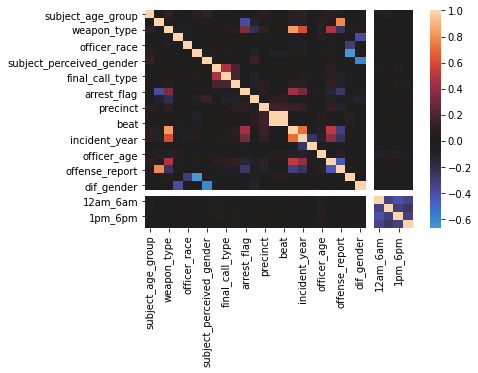

In [19]:
sns.heatmap(data=t_stops.corr(), center=0)

In [21]:
# creating a date frame that only contains the pairs of values with highest 
# correlation

# converts all elements to absolute values, stacks into multi-index, resets 
# the index to set the multi-index to seperate columns, and finally sorts them
corr_pairs = t_stops.corr().abs().stack().reset_index().sort_values(0, 
                                                                ascending=False)
# zipping the variable name columns
corr_pairs['pairs'] = list(zip(corr_pairs.level_0, corr_pairs.level_1))

#set index to the pairs
pairs_index = corr_pairs.set_index(['pairs'])

#dropping level columns
pairs = pairs_index.drop(columns=['level_0', 'level_1'])

#renaming column for comprehension
pairs.columns = ['correlation']
#Since our heatmap shows that our variables only show perfect correlation with 
#themselves, we'll drop duplicates
unique_pairs = pairs.drop_duplicates()

unique_pairs[(unique_pairs.correlation>0.75) & (unique_pairs.correlation<1)]

,correlation
pairs,
"(sector, beat)",0.997707
"(weapon_type, repeat_offenders)",0.833398
"(stop_resolution, offense_report)",0.781726


By reducing to only a single neighbor, we've increased the accuracy to 62%! Something that can be done to further increase accuracy is to eliminate some of the columns.  Some of these columns that have 